# Police Brutality: A Data-Driven Investigation

This last notebook delves into a statistical analysis of the complex and disturbing phenomenon of police brutality.  Our investigation employed various tools and techniques to uncover patterns and potential contributing factors:

**Data Visualization:**

* **Distributions:** Count plots and stacked bar charts illuminated the distribution of fatalities across demographics like age, race, and threat level.
* **Temporal Trends:** Line plots revealed patterns across years, months, days of the week, and even lunar phases.

**Statistical Analysis:**

* **Relationships:** Chi-squared tests were employed to examine the statistical significance of relationships between variables such as race, lunar phase, threat level, and mental illness involvement. 

**Key Findings:**

* **Lunar Lunacy:** Our analysis unearthed a peculiar (and likely coincidental) correlation between lunar phases and specific incident types. Werewolves on the force?  Probably not, but this oddity demands further scrutiny.

* **Demographic Disparity:** Sadly unsurprising, the majority of victims in our dataset were white male adults. This underscores the need to examine potential biases within policing practices.  

* **The Wednesday Curse:** Wednesdays emerged as the deadliest day of the week. Let's hope it's just a statistical fluke and not a sign of cosmic malice.

* **A Glimmer of Hope?** Data reveals a marked decline in police brutality incidents over time. While encouraging, we must remain vigilant to ensure this trend continues.

**Questions & Next Steps:**

This analysis raises important questions about the complex factors influencing police brutality.  Future research could:

* **Expand Scope:** Investigate the impact of additional variables (e.g., officer training, socioeconomic factors, community policing).
* **Refine Clustering:** Experiment with alternative clustering methods for potentially deeper insights.
* **Develop Predictive Models:** Build models to identify high-risk situations and inform preventative strategies.

**Let's continue this data-driven exploration to shed light on this critical issue and work towards solutions.**


### 7. Recalling Our Prepped Data: Initialization

*Time to reap the benefits of our past diligence. Let's load our meticulously transformed and saved Parquet file and import the necessary libraries for our final analysis. This gives us a pristine starting point for clustering and further exploration.* 


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_parquet("police_brutality_outliers.parquet")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9494 entries, 3 to 10272
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        9494 non-null   datetime64[ns]
 1   threat_type                 9494 non-null   category      
 2   flee_status                 9494 non-null   category      
 3   armed_with                  9494 non-null   category      
 4   city                        9494 non-null   category      
 5   county                      9494 non-null   category      
 6   state                       9494 non-null   category      
 7   latitude                    9494 non-null   float64       
 8   longitude                   9494 non-null   float64       
 9   location_precision          9494 non-null   category      
 10  name                        9494 non-null   string        
 11  age                         9494 non-null   float64       
 

### 8. Exploring Intriguing Features

_Let's take a closer look at our categorical features, especially those we constructed ourselves.  We might uncover some unexpected patterns..._

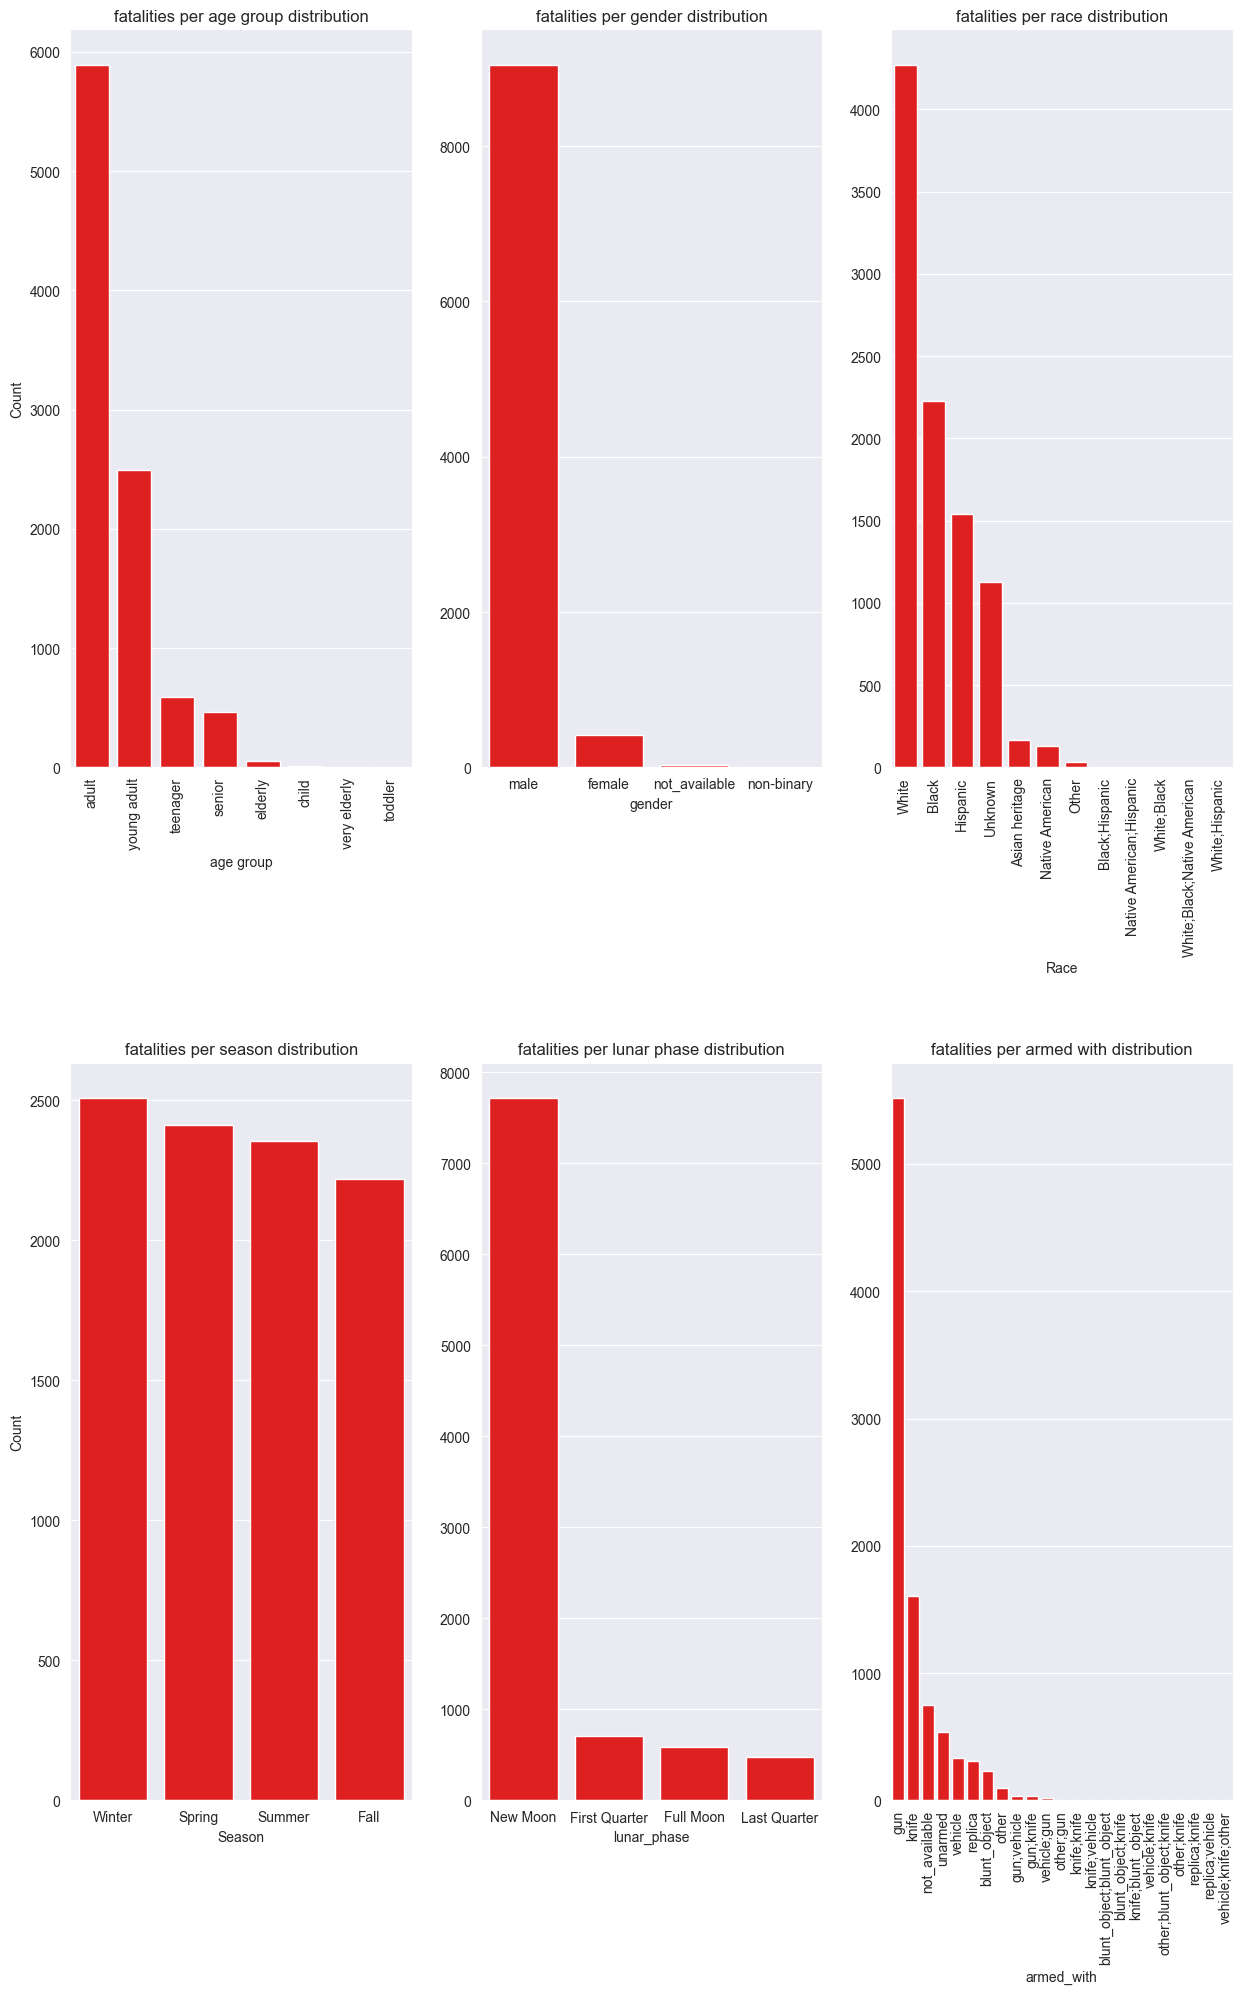

In [4]:
def plot_count_distribution(
    data, column, title, xlabel, ylabel, ax, rotation=0, labelsize=10
):
    """
    Plot the count distribution of a categorical column.
    Parameters:
    - data: DataFrame, the input data.
    - column: str, the categorical column for plotting.
    - title: str, title of the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - ax: Axes, matplotlib axes for the plot.
    - rotation: int, optional, rotation angle for x-axis labels (default is 45).
    Example:
    plot_count_distribution(df, 'course_Certificate_type',
                             'Certificate Type distribution',
                            'Certificate Type', 'Count', axes[0])
    """
    order = data[column].value_counts().index
    sns.countplot(x=column, data=data, ax=ax, color="red", order=order)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=rotation, labelsize=labelsize)
    plt.subplots_adjust(hspace=0.4)


fig, axes = plt.subplots(2, 3, figsize=(15, 23))
plot_count_distribution(
    df,
    "age_group",
    "fatalities per age group distribution",
    "age group",
    "Count",
    axes[0, 0],
    rotation=90,
)
plot_count_distribution(
    df, "gender", "fatalities per gender distribution", "gender", " ", axes[0, 1]
)
plot_count_distribution(
    df,
    "race",
    "fatalities per race distribution",
    "Race",
    " ",
    axes[0, 2],
    rotation=90,
    labelsize=10,
)
plot_count_distribution(
    df, "season", "fatalities per season distribution", "Season", "Count", axes[1, 0]
)
plot_count_distribution(
    df,
    "lunar_phase",
    "fatalities per lunar phase distribution",
    "lunar_phase",
    " ",
    axes[1, 1],
)
plot_count_distribution(
    df,
    "armed_with",
    "fatalities per armed with distribution",
    "armed_with",
    " ",
    axes[1, 2],
    rotation=90,
    labelsize=10,
)

### The New Moon Anomaly: A Puzzling Trend

Let's examine the distribution of values within our categorical features, paying close attention to any unexpected patterns.  One constructed feature, the lunar phase, reveals a shocking trend: the highest concentration of fatalities seems to occur during the new moon.  This counter-intuitive finding stands in contrast to common astrological beliefs that might point to the full moon.

**Questions to Ponder:**

* **Coincidence or Correlation?** Could this be a statistical fluke, or does a deeper connection exist?
* **Potential Explanations:**  Are there any factors associated with new moon phases (darkness, etc.) that could indirectly contribute to an increase in these incidents?

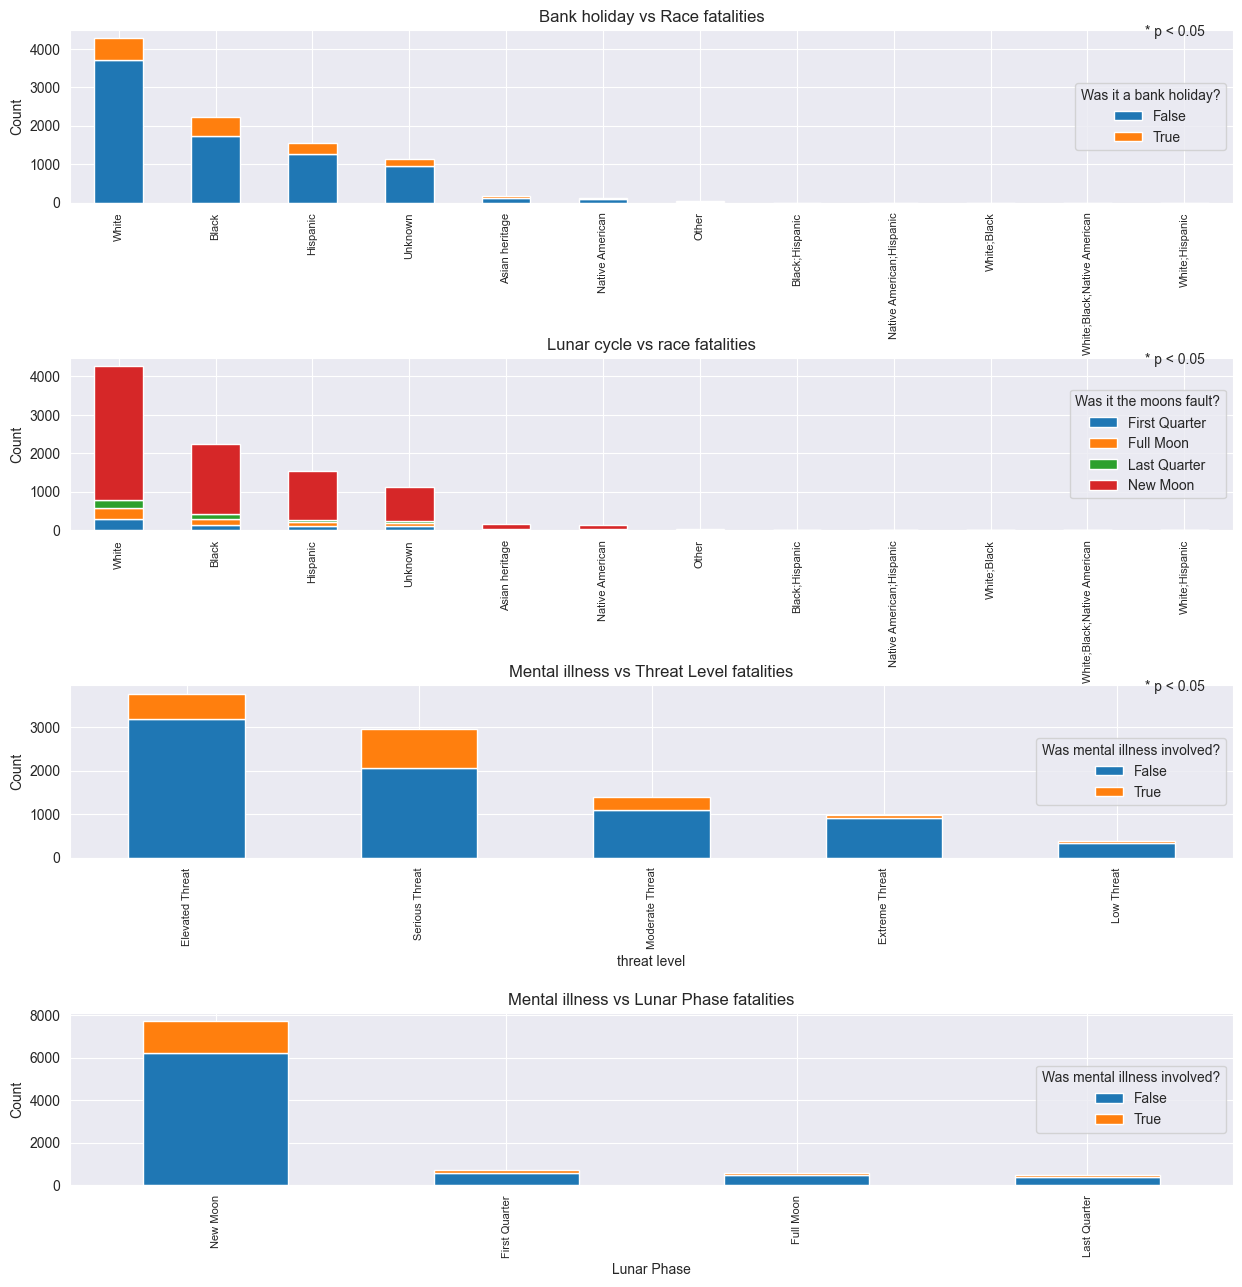

In [5]:
def plot_stacked_cross_tab(
    df,
    variable1,
    variable2,
    title=None,
    xlabel=None,
    ylabel=None,
    legend_title=None,
    ax=None,
    labelsize=8,
    significance_level=0.05,
    **kwargs
):
    """
    Creates a stacked bar plot using a provided axes object.
    """
    cross_tab = pd.crosstab(df[variable1], df[variable2])
    totals_per_category = cross_tab.sum(axis=1)
    order = totals_per_category.sort_values(ascending=False).index
    cross_tab = cross_tab.reindex(order)

    cross_tab.plot.bar(stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title, loc="center right")
    ax.tick_params(axis="x", labelsize=labelsize)
    plt.subplots_adjust(hspace=0.9)

    cross_tab = pd.crosstab(df[variable1], df[variable2])
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(cross_tab)

    significance_str = (
        ("* p < {}".format(significance_level))
        if (p_value < significance_level)
        else ""
    )
    ax.text(
        0.95,
        0.95,
        significance_str,
        ha="center",
        va="bottom",
        transform=ax.transAxes,
        fontsize=10,
    )


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))

plot_stacked_cross_tab(
    df,
    "race",
    "body_camera",
    title="Bank holiday vs Race fatalities",
    xlabel="race",
    ylabel="Count",
    legend_title="Was it a bank holiday?",
    ax=axes[0],
)

plot_stacked_cross_tab(
    df,
    "race",
    "lunar_phase",
    title="Lunar cycle vs race fatalities",
    xlabel="race",
    ylabel="Count",
    legend_title="Was it the moons fault?",
    ax=axes[1],
)

plot_stacked_cross_tab(
    df,
    "threat_level",
    "was_mental_illness_related",
    title="Mental illness vs Threat Level fatalities",
    xlabel="threat level",
    ylabel="Count",
    legend_title="Was mental illness involved?",
    ax=axes[2],
)

plot_stacked_cross_tab(
    df,
    "lunar_phase",
    "was_mental_illness_related",
    title="Mental illness vs Lunar Phase fatalities",
    xlabel="Lunar Phase",
    ylabel="Count",
    legend_title="Was mental illness involved?",
    ax=axes[3],
)

### Exploring Intersections: Lunar Phase, Race, and Mental Illness

The surprising trend of higher fatalities during the new moon persists across all races. This raises even more complex questions. Let's explore potential interactions with other factors:

* **Mental Health and Threat Level:**  Does mental illness correlate with perceived threat level? Could the combination of a new moon and mental illness influence the outcome of these incidents?

* **Visual Confirmation:**  It seems like there might be a relationship between the new moon, mental illness, and perceived threat level... but the data might be deceiving us.  Let's dig deeper and avoid jumping to conclusions.

**Next Steps:**

1. **Visualization:** Cross-tabulation visualizations could illuminate these potential relationships.
2. **Statistical Tests:** Employ statistical tests to determine if any apparent connections are significant.

_We need to tread carefully here – the data might reveal genuine patterns or might be leading us down a rabbit hole._ 


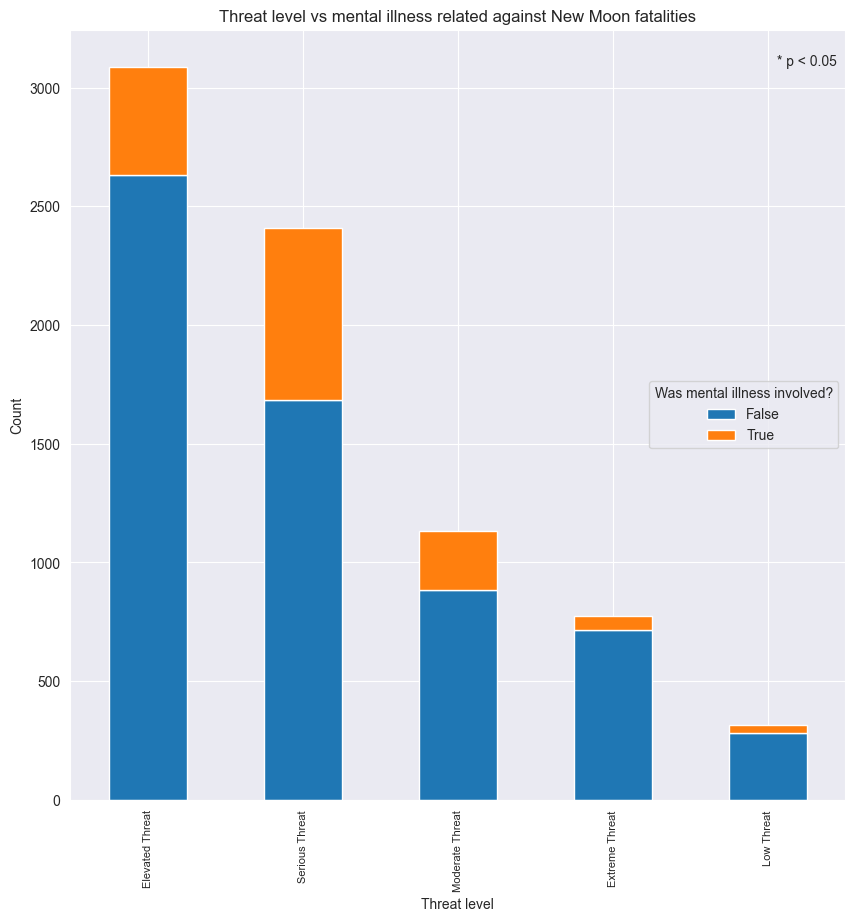

In [6]:
new_moon_df = df[(df["lunar_phase"] == "New Moon")]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

plot_stacked_cross_tab(
    new_moon_df,
    "threat_level",
    "was_mental_illness_related",
    title="Threat level vs mental illness related against New Moon fatalities",
    xlabel="Threat level",
    ylabel="Count",
    legend_title="Was mental illness involved?",
    ax=axes,
)

### Shifting Focus: Temporal Trends

While the lunar phase analysis raises intriguing questions, let's pivot to a different perspective.  How do fatality counts fluctuate across various time periods?

**Exploration Plan:**

* **Yearly Trends:**  Do we see patterns over years?  Are incidents increasing, decreasing, or remaining stable?
* **Monthly Patterns:**  Are specific months associated with higher or lower fatality counts?
* **Weekday Insights:**  Do certain days of the week reveal any trends?
* **Daily Fluctuations:**  Examine if the specific day within a month has any impact.  

_**Note:** Let's see if time itself reveals any hidden patterns within this dataset._ 


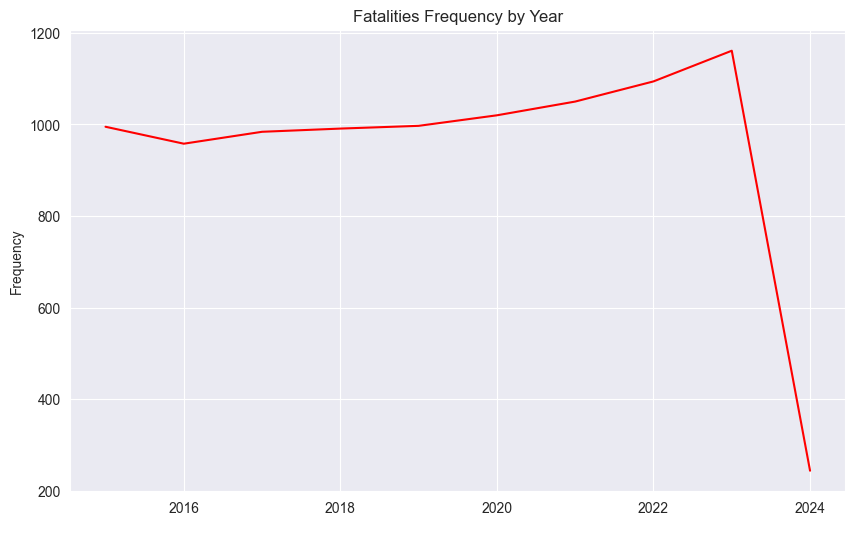

In [7]:
yearly_counts = df.groupby("year", observed=True)["date"].count()
monthly_counts = df.groupby("month", observed=True)["date"].count()
weekday_counts = df.groupby("day_of_week", observed=True)["date"].count()
day_counts = df.groupby("day", observed=True)["date"].count()


def plot_shooting_frequency(series, period="Year"):
    """
    Creates a line plot visualizing the frequency of shootings over time.
    Args:
        series (pandas.Series): A Series containing yearly shooting counts. The index
                                must represent years, and the values represent frequencies.
        period (str, optional): The time period to use for the x-axis label.
                                Defaults to 'Year'.
    """

    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, color="red")
    plt.xlabel(" ")
    plt.ylabel("Frequency")
    plt.title(f"Fatalities Frequency by {period}")
    plt.show()


plot_shooting_frequency(yearly_counts, "Year")

### A Glimmer of Hope: A Potential Decline

Our analysis reveals an encouraging sign: a notable decline in police brutality incidents starting in 2023.  While it's important to remain cautious until we have more long-term data, this trend is worth celebrating and analyzing further.

**Questions to Consider:**

* **Underlying Factors:** What might be driving this decline? Could it be related to policy changes, increased training, shifts in public awareness, or other factors?
* **Sustainability:**  Will this downward trend continue?  What actions are needed to ensure that it does?

_**Note:** Let's hope this positive shift is not just a temporary blip but a sign of genuine and lasting progress._


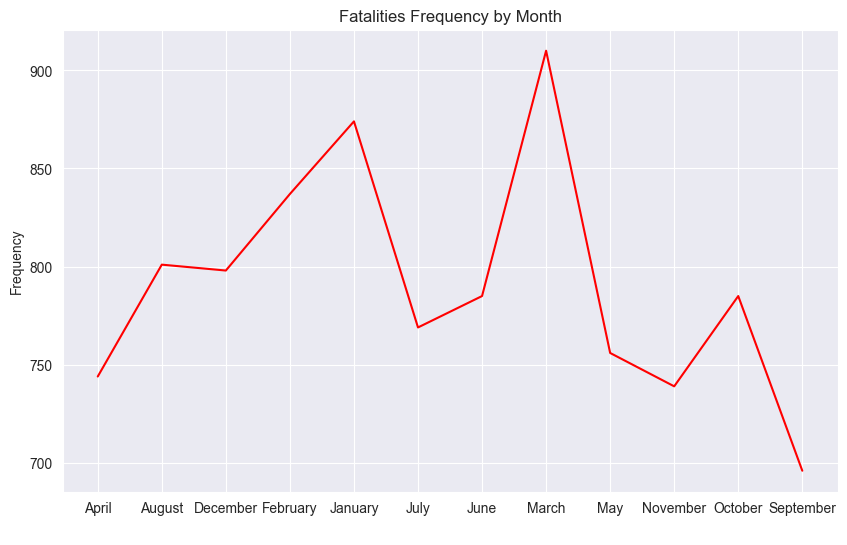

In [8]:
plot_shooting_frequency(monthly_counts, "Month")

### Wednesday Woes: A Mid-Week Spike

Hold on to your hats!  Our analysis reveals a peculiar pattern – Wednesdays seem to hold the dubious distinction of having the highest concentration of police brutality incidents.  Is it the mid-week blues?  A cosmic conspiracy?

* **Potential Causes:**  What factors might contribute to this Wednesday spike?  Is it purely coincidence, or are there specific patterns at play?

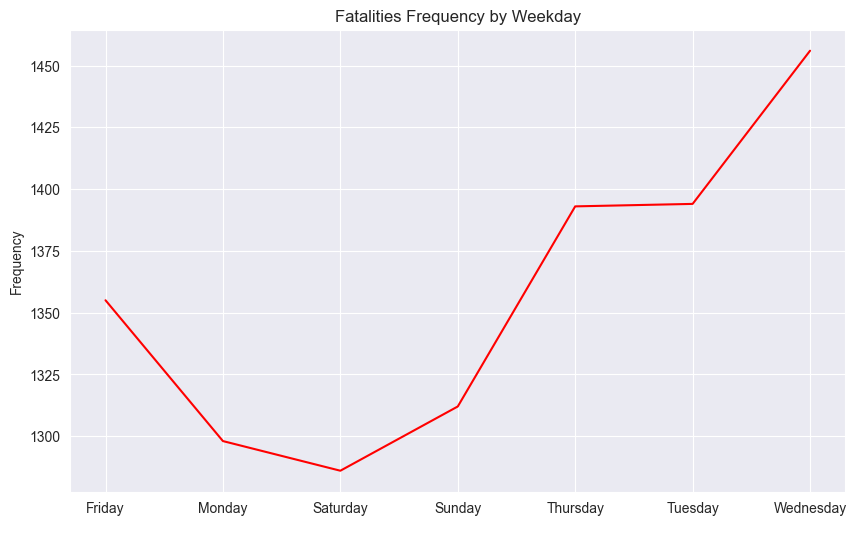

In [9]:
plot_shooting_frequency(weekday_counts, "Weekday")

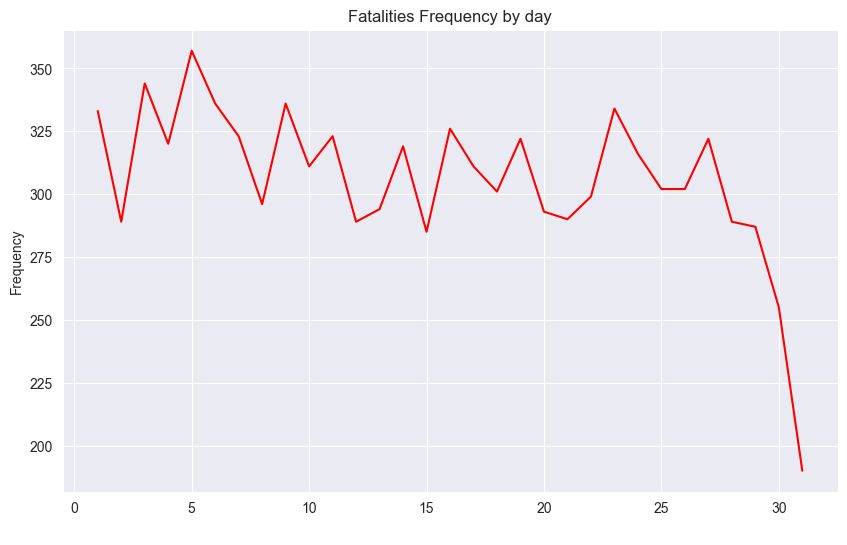

In [10]:
plot_shooting_frequency(day_counts, "day")

### 9. Beyond the Numbers:  Continuing the Investigation

Our analysis has unveiled intriguing trends and raised important questions.  To achieve a more comprehensive understanding of police brutality, here's where we could go next:

**Questions for Further Exploration**

* **Expanding our Scope:** What additional factors (officer experience, socioeconomic context, community policing models, etc.) could shed light on these incidents? 
* **Refining our Clustering:**  Could different clustering algorithms or feature combinations reveal even more nuanced patterns within the data?  

**Next Steps**

* **Gather More Data:** Incorporate additional variables to broaden the scope of analysis.
* **Experiment with Visualizations:** Test various visualization techniques to uncover hidden relationships.
* **Predictive Modeling:** Develop models to potentially identify high-risk situations and inform preventative strategies.

This investigation is far from over. Let's use data as a powerful tool to seek deeper insights and drive positive change. 
